In [11]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import time
import scienceplots
import torchsummary

import dataset
import data_Preprocess 
import models
import uLoss
import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('device = ',device)
seed = 123 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
plt.style.use('science')
plt.rcParams['text.usetex'] = False

device =  cuda:0


In [98]:
param = {
    'mesh_size':[0.1,0.1],
    'structure_size':[10,10],
    'measurements_num':9,
    'device':device,
    'is_plotInputMap':False,
    'Lambda':0.0,
    'HS_region':torch.tensor(([[[1.5,2.5],[6.9,8.4]],# region_1
                               [[4.4,8.4],[7.2,8.0]],# region_2
                               [[0.6,1.6],[5.0,6.0]],# region_3(1)
                               [[0.6,3.1],[4.0,5.0]],# region_3(2)
                               [[1.0,4.0],[0.8,2.8]],# region_4
                               [[5.6,8.6],[1.3,4.9]]])),# region_5
    'BCs':['Neumann','Convection','Radiation','Radiation'],# top,bottom,left,right
    'Heat Transfer Rate':52,
    'Convective coe':10,
    'Emissivity':0.05,
    'q':15,
    'T_a':20,
    'BC_regular':True,
    'HS_regular':False,
    'learning_rate': 0.005,
    'epochs': 5000,
    'dis_interval': 500,
    'is_plotLoss':True,
    'is_plotResult':False    
    
}

In [99]:
train_set = dataset.MyDataset('Train','Co-driven',param)
test_set = dataset.MyDataset('Test','Co-driven',param)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                          batch_size = 32,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 100,
                                          shuffle = False)
trues = data_Preprocess.get_Tfields('Test').unsqueeze(1)

In [100]:
torch.manual_seed(1)
loads = torch.rand(1,5)
Trues = [50, 64, 78, 90, 72]
setType = 'Test'
print ('Trues = {}'.format((torch.tensor(Trues)-20.0)/80.0))
print ('Initial = {}'.format(loads))

Trues = tensor([0.3750, 0.5500, 0.7250, 0.8750, 0.6500])
Initial = tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293]])


In [107]:
class inversePINNs():
    def __init__(self,loads,setType,SampleNum,param):
        self.loss_function = nn.MSELoss(reduction ='mean')
        loads = loads.to(param['device'])
        self.loads = nn.Parameter(loads)
        self.model = models.UNet(in_channels=1, out_channels=1, factors=2,param=param).to(param['device'])
        self.param = param
        self.setType = setType
        self.task_num = 5
        sigma = torch.rand(self.task_num).to(param['device'])
        self.sigma = nn.Parameter(sigma)
        paths = data_Preprocess.getDataPath()  
        MPsNames = data_Preprocess.findTargetFiles_measurements(paths,self.setType,dataType='measurements',param = self.param)
        self.Data = data_Preprocess.addGaussianNoise(data_Preprocess.transferToTensor(data_Preprocess.loadData_fromFiles(MPsNames[SampleNum])),self.param)
        self.Trues = self.Data[:,-1]
        self.MPs = data_Preprocess.generate_Map(MPsNames[SampleNum],self.param).unsqueeze(0)
        
    def forward_comp(self):
        self.out = self.model(self.MPs.unsqueeze(0))
        mesh_size = self.param['mesh_size']
        hx = mesh_size[0]
        hy = mesh_size[1] 
        load = self.loads*80.0+20.0
        count = 0
        for i in self.param['HS_region']:
            if count < 3:
                value = load[0][count]
            else:
                value = load[0][count-1]
            mask = torch.zeros_like(self.out)
            mask[:, :, round(i[0][0].item()/hx):round(i[0][1].item()/hx)+1, round(i[1][0].item()/hy):round(i[1][1].item()/hy)+1] = 1
            self.out = self.out * (1 - mask) + value * mask
            count = count + 1        
    
    def loss_data(self):
        Preds = []
        for i in self.Data:
            coord = []
            for j in range(len(i[:-1])):
                coord.append(i[j]/self.param['mesh_size'][j])
            Preds.append(self.out[0][0][round(coord[0].item())][round(coord[1].item())])
        Preds = torch.stack(Preds)
        loss_u = self.loss_function(self.Trues,Preds)
        return loss_u
    
    def loss_PDE(self):
        mesh_size = self.param['mesh_size']
        hx = mesh_size[0]
        hy = mesh_size[1] 
        load = self.loads*80.0+20.0
        '''plt.imshow(self.out.cpu().view(101,101).detach().numpy(),cmap='rainbow')
        plt.colorbar()
        plt.title('after loss_p')
        plt.show()'''
        losses = 0
        self.loss_t_inner = uLoss.loss_T_inner(self.out,self.param)
        self.loss_t_neumann = uLoss.loss_neumann(self.out,self.param)
        self.loss_t_radiation = uLoss.loss_radiation(self.out,self.param)
        self.loss_t_convection = uLoss.loss_convection(self.out,self.param) 
    
    def loss(self):
        losses = 0
        self.forward_comp()
        loss_d = self.loss_data()
        if loss_d>0.1:
            losses += (0.5/(self.sigma[4]**2)*loss_d + torch.log(self.sigma[4]**2+1))  
        self.loss_PDE()
        losses += 40*(0.5/(self.sigma[0]**2)*self.loss_t_inner + torch.log(self.sigma[0]**2+1))  
        losses += 4*(0.5/(self.sigma[1]**2)*self.loss_t_neumann + torch.log(self.sigma[1]**2+1)) 
        losses += 3*(0.5/(self.sigma[2]**2)*self.loss_t_radiation + torch.log(self.sigma[2]**2+1))
        losses += 1*(0.5/(self.sigma[3]**2)*self.loss_t_convection + torch.log(self.sigma[3]**2+1))
        return losses,loss_d,self.loss_t_inner,self.loss_t_neumann,self.loss_t_radiation,self.loss_t_convection


In [108]:
PINN = inversePINNs(loads,setType,32,param)
allParameters = list(PINN.model.parameters()) + [PINN.sigma] + [PINN.loads]
optimizer = torch.optim.Adam(allParameters, lr =0.002) #param['learning_rate'])
for epoch in range(40000):
    optimizer.zero_grad()
    losses,loss_d,loss_t_inner,loss_t_neumann,loss_t_radiation,loss_t_convection = PINN.loss()
    losses.backward()
    optimizer.step()
    if (epoch % param['dis_interval'] == 0) or (epoch + 1 == param['epochs']):
        print ('Traing Epoch: {}, loss = {}'.format(epoch,losses))
        print (loss_d.item(),loss_t_inner.item(),loss_t_neumann.item(),loss_t_radiation.item(),loss_t_convection.item())
        print("Predicted loads:", PINN.loads.cpu())
        #print('sigma={}'.format(PINN.sigma))
        print ('########################################')

Traing Epoch: 0, loss = 3490.77978515625
2566.48046875 0.031438861042261124 0.08316030353307724 0.07001623511314392 0.07201532274484634
Predicted loads: tensor([[0.7556, 0.2773, 0.4011, 0.7327, 0.0313]], grad_fn=<ToCopyBackward0>)
########################################
Traing Epoch: 500, loss = 16.9265193939209
8.862446784973145 0.018561700358986855 0.05458805710077286 8.33520243759267e-05 0.009281945414841175
Predicted loads: tensor([[ 3.7961e-01,  8.8886e-05, -3.0366e-05,  8.2487e-06,  5.7156e-01]],
       grad_fn=<ToCopyBackward0>)
########################################
Traing Epoch: 1000, loss = 9.387629508972168
0.09886816889047623 0.019942117854952812 0.04484863579273224 0.0001458867482142523 0.008963283151388168
Predicted loads: tensor([[ 3.7159e-01,  4.2314e-04,  1.4054e-05, -1.9969e-05,  6.4205e-01]],
       grad_fn=<ToCopyBackward0>)
########################################
Traing Epoch: 1500, loss = 9.245918273925781
0.09637445211410522 0.019832534715533257 0.04359041899

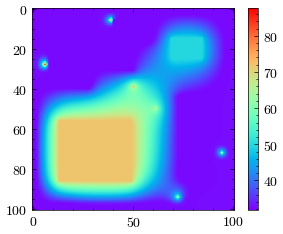

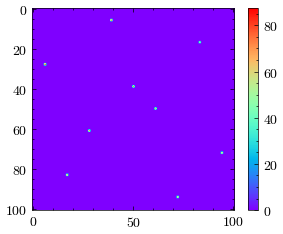

In [109]:
out = PINN.out
plt.imshow(out.view(101,101).cpu().detach().numpy(),cmap="rainbow")
plt.colorbar()
plt.show()
plt.imshow(PINN.MPs.view(101,101).cpu().detach().numpy(),cmap="rainbow")
plt.colorbar()
plt.show()